# Measure initial permeability

You don't need to know initial permeability to plot chart of complex permeability, but you need this value to find matching core material in manufacturers datasheets.

If you can measure inductance with LCR meter. Make one loop over the toroid, measure inductance and torroid dimensions.

It is vital that this measurement is done with as few turns as necessary to give a reliable and accurate reading on the
measuring instrument. More turns means decreased self resonant frequency and the impedance will no longer
obey the simple model 

$\frac{X}{R}=\frac{\mu'}{µ''}$

If the inductor has appreciable flux leakage (eg a rod or low µ), then the flux leakage results in a departure from the formula above.


Magnetic permeability $\mu$ is the ability of a magnetic material to support the formation of a magnetic field. The initial permeability $\mu_i$ is the purely amplitude permeability of the ferrite core when the magnetic field (B) is close to “zero” as shown in the below B-H curve figure.

<img src="mu.jpeg">

Initial permeability describes the relative permeability of a material at low values of B (below 0.1T). The maximum value for $\mu$  in a material is frequently a factor of between 2 and 5 or more above its initial value.

The magnetic permeability $\mu$ can be interpreted as “conductivity for magnetic flux”. The initial permeability is determined by the following formula, which is related to the applied magnetic material, its dimensions and shape.

<img src="mu2.png">

$L=\frac{\mu_0*\mu_r*N^2}{2*\pi}*h*log_e(\frac{r_o}{r_i})$

$\mu_0$ - magnetic constant $4*\pi*10^{-7} [\frac{T * m}{A}]$

src https://coil32.net/ferrite-toroid-core.html

From here we can compute $\mu_i$

In [1]:
import math

# measured values with one turn over torroid.
od = 25 #mm
id = 15 #mm
width = 10 #mm, the h symbol in the formula above
turns=2 #use least turns possible to minimise self resonance effects
L=1 #uH  @ 10kHz

#The initial permeability defines the relative permeability at low excitation level.
#According to IEC 60401 test condition : f<= 10 KHz, B < 0.25mT, 25


# notice that the formula adapted to uH
mu_init = L/(0.0002*width*turns**2*math.log(od/id))
print("initial relative magnetic permeability of the core = ", mu_init, "[dimensionless quantity]")

initial relative magnetic permeability of the core =  244.7018986214022  dimensionless quantity


# Compute inductance factor of the core

We will use this measured initial magnetic permeability of the core to compute $A_L$ parameter - the inductance factor of the core

$A_L=0.2*\mu_i*h*log_e(\frac{r_o}{r_i})$

Mathematically, the AL has the SI unit henry (H), but the the relationship to inductance is non-linear and the practical unit is nanohenry per square turn or $nH \over turn^2$

Relative permeability can be expressed as a complex quantity to capture both the ability of the core to increase flux and the core loss.

$Z = j 2 \pi  f  N^2  A_l  \frac{\mu'-j*\mu''}{\mu_{initial}}$

In [3]:
#width is the h symbol in the formula above
al=0.2*mu_init*width*math.log(od/id)
print("Al=",al, "nano henries per square turn")

mu_0=4e-7*math.pi # magnetic constant
a_over_l=al/(mu_0*mu_init*1e9);
print("A/l=",a_over_l)


Al= 250.0 nano henries per square turn
A/l= 0.000813004230803582


# Take measurements of the toroid with VNA

* Callibrate the VNA with the testing fixture
* Setup the toroid in the testing fixture
* Configure sweep 50kHz .. 400Mhz
* Run nano-VNA, record measurements into *.s1p file (Touchstone file format)
* Process raw data with the script below

Fixture used here

<img src="fixture-a.jpg" width="400">

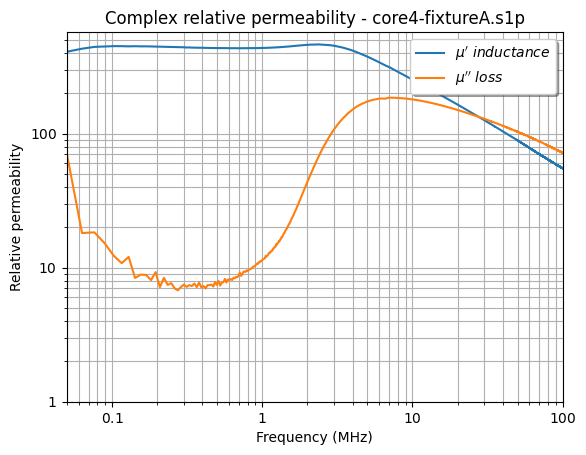

In [5]:
import matplotlib.pyplot as plt
import skrf as rf
import numpy

file1='core4-fixtureA.s1p'

nw1=rf.Network(file1)
# notice how measured Z (resistance, reactance) is inverted down below, 
# mu = Z*a_over_l/(2*pi*f*N2*1j*mu_0)
# when a complex number is divided by 1j the real part value become imaginary 
# and the imaginary become the real.
# permeability affects inductance i.e. reactance part of Z, the real part of Z are ohmic losses
# in the plot below we use mu.real for inductance
# and mu.imag for losses
mu=(nw1.z[:,0,0]/turns**2/(2*math.pi*nw1.f)/1j)/(mu_0*a_over_l)

plt.figure()
plt.rcParams['axes.formatter.min_exponent'] = 4
plt.plot(nw1.f/1e6,mu.real,label='mu1')
plt.plot(nw1.f/1e6,-mu.imag,label='mu2')
plt.xscale('log')
plt.yscale('log')
plt.legend(('$\mu\'\ inductance$','$\mu\'\'\ loss$'),loc='upper right',shadow=True)
plt.ylim(bottom=1)
plt.xlim(left=0.05, right=100)
plt.ylabel('Relative permeability')
plt.xlabel('Frequency (MHz)')
plt.title('Complex relative permeability - {}'.format(file1))
plt.grid(True, which="both")
plt.show()

To determine the core material - note the frequency where losses become dominant, note initial permeability

# Check manufacturers

| Name      | Site |
| ----------- | ----------- |
|Fair-Rite|http://www.fair-rite.com|
|Ferroxcube(Yageo)|http://www.yageo.com|
|Magnetics|http://www.mag-inc.com|
|Micrometals|http://www.micrometals.com|
|Amidon Company|http://www.amidoncorp.com|

src https://www.nutsvolts.com/magazine/article/July2015_HamWorkbench

---
core4 sample appears to be material simmilar or identical to material 52

> A new high frequency NiZn ferrite material that combines a high saturation flux density and a high Curie temperature.

<img src="52_uuvsF.jpeg">

https://www.fair-rite.com/52-material-data-sheet/

https://www.amidoncorp.com/product_images/specifications/52_Material.pdf

## Saturation current

Check `Flux Density @ Field Strength` row in the datasheet. See max Oersted (H) number. This is where this material saturates. It can also be determined graphically from the Hysteresis Loop: the point where the two black lines meet at the upper-right is saturation.


$1 \mathrm{Oe}= {1000 \:\mathrm A \over 4 \pi \:\mathrm m}\approx 79.58 \: \mathrm A / \mathrm m$

Calculate for inductor we about to wind. For example, say we have a toroidal core with a circumference of 4cm, with 10 turns on it, with 500mA. The field strength is then:

$$\begin{align}
\frac{10 \cdot 0.5 \:\mathrm A}{0.04 \:\mathrm m} &= 125\:A/\mathrm m \\
125\: \mathrm A/ \mathrm m \cdot \frac{4 \pi}{1000} &\approx 1.57\: \mathrm{Oe}
\end{align}$$

This is less than the 10 Oe in the datasheet, so the core is not saturated.

## Refrences

* [EstimateZFerriteToroidInductor.pdf](EstimateZFerriteToroidInductor.pdf)
* https://www.fair-rite.com/materials/
* https://ham.stackexchange.com/questions/1159/how-does-one-read-a-ferrite-datasheet
* http://przyrbwn.icm.edu.pl/APP/PDF/117/a117z522.pdf
* https://coil32.net/ferrite-toroid-core.html